<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/NLP/TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> We are the SSJ team and this is our work about natural language processing.

---

In [51]:
import io
import pandas as pd
from google.colab import files
import re
from ast import literal_eval

## 0. Loading Data

We start by loading the data file that contains the tweets with which the study will work. The file format to upload is CSV.

For this purpose, we use some commands provided by Google Colab itself to access files on our computer.

In [52]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),sep=',')
  
with_e = []
without_e = []
for i in range(0,len(df)):
  without_e.append(literal_eval(df.iloc[i]['preprocessing_without_emoticons']))
  with_e.append(literal_eval(df.iloc[i]['preprocessing_with_emoticons']))

df['preprocessing_without_emoticons'] = without_e
df['preprocessing_with_emoticons'] = with_e

df

Saving prepocessed_data.csv to prepocessed_data (4).csv
User uploaded file "prepocessed_data.csv" with length 3579701 bytes


,Unnamed: 0,preprocessing_without_emoticons,preprocessing_with_emoticons,class
0,0,"[woman, complain, cleaning, house, man, always...","[woman, complain, cleaning, house, man, always...",2
1,1,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",1
2,2,"[dawg, !, !, !, ever, fuck, bitch, start, cry,...","[dawg, !, !, !, ever, fuck, bitch, start, cry,...",1
3,3,"[look, like, tranny]","[look, like, tranny]",1
4,4,"[shit, hear, might, true, might, faker, bitch,...","[shit, hear, might, true, might, faker, bitch,...",1
...,...,...,...,...
24778,24778,"[yous, muthaf, lie, right, !, TL, trash, mine,...","[yous, muthaf, lie, right, !, TL, trash, mine,...",1
24779,24779,"[gone, broke, wrong, heart, baby, drove, redne...","[gone, broke, wrong, heart, baby, drove, redne...",2
24780,24780,"[young, buck, wanna, eat, !, !, dat, nigguh, l...","[young, buck, wanna, eat, !, !, dat, nigguh, l...",1
24781,24781,"[youu, got, wild, bitch, tellin, lie]","[youu, got, wild, bitch, tellin, lie]",1


# 2. Vectorization

When the tweets are preprocessed, we can start to obtain information from them.

The goal of this section is to obtain a dataframe with all the information which will be used for the next one, in order to classify the tweets.


## Destokenizador

To do the vectorization, we have chosen to put back all the tokens that make a sentence. We think that this will make the development of this process easier.

In [53]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

tweets_detokenize_with_emoticon = []
tweets_detokenize_without_emoticon = []

for i in range(0,len(df_result)):
  tweets_detokenize_with_emoticon.append( TreebankWordDetokenizer().detokenize(df_result.iloc[i]['preprocessing_with_emoticons']))
  tweets_detokenize_without_emoticon.append( TreebankWordDetokenizer().detokenize(df_result.iloc[i]['preprocessing_without_emoticons']))

df_result['detokenization_with_emoticons'] = tweets_detokenize_with_emoticon
df_result['detokenization_without_emoticons'] = tweets_detokenize_without_emoticon
df_result

NameError: ignored

## TFIDF

In order to start using TFIDF, we will first have to create a TFIDFVectorizer.

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. Three steps at once

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer,min_df=1,lowercase=False)



X = vectorizer.fit_transform(df['preprocessing_with_emoticons'])
#Y = vectorizer.fit_transform(tweets_detokenize_with_emoticon)

This is the TFIDF of the first tweet of the CSV file (whitout emoticons).

In [55]:
print(df['preprocessing_with_emoticons'][3])
print(X[3])

['look', 'like', 'tranny']
  (0, 16628)	0.7792014398167064
  (0, 10157)	0.35264955140182924
  (0, 10321)	0.5181538478904314


In [56]:
X.shape[1] * 0.3

5486.099999999999

We are going to calculate the TFIDF of both the tweets without emoticons and those that keep them, and we will save them in our dataset.

# 3. Select features

We have created a new dataset where we have put the characteristics with which we will work from now on. With this dataset, feature selection will be made.

With the following graph, we check the correlations that exist between the variables of the dataset.

To carry out the selection of characteristics, the selectKBest function will be used. You will have to pass it the number of "top" characteristics that it will choose from the existing ones.

In [57]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif
import numpy as np

# Create features and target variable for Classification problem
X_clf = X 

y_clf = df['class'] # Target variable: class
print(y_clf)

y_clf = np.where(y_clf == 0,0, y_clf)
y_clf = np.where(y_clf == 1,1, y_clf)
y_clf = np.where(y_clf == 2,2, y_clf)
y_clf = y_clf.astype('int')
print(y_clf)

n_k = round(X.shape[1] * 0.3)

best=SelectKBest(score_func = mutual_info_classif, k = n_k)
X_new = best.fit_transform(X_clf, y_clf)
X_new.shape
selected = best.get_support(indices=True)
#print(X_clf.columns[selected]) #error borrar

0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64
[2 1 1 ... 1 1 2]


AttributeError: ignored

With k = 2, the two characteristics that SelectKBest returns are *'Negative'* and *'Compound'*. To these two features we will add the target feature, *'class'*.

# 4. Classification algorithm

Once we know the three characteristics with which we are going to work, it is time to separate the dataset records in the training part and the test part. The test part will be made up of 30% of the tweets.

In [58]:
#from sklearn.model_selection import train_test_split

#train, test = train_test_split(X_new, test_size=0.3)
#train.reset_index(inplace = True)
#test.reset_index(inplace = True)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_clf, test_size=0.3, random_state=0)
#train.reset_index(inplace = True)
#test.reset_index(inplace = True)

In [59]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
#import numpy as np

cv = KFold(n_splits = 5, shuffle = True) 

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train):
          # Random train / test division
          f_train = X_train.loc[train_fold]
          f_test = X_train.loc[test_fold]
          # Model training and execution
          knn.fit( X = f_train.drop(['class'], axis=1), 
                               y = f_train['class'])
          y_pred = knn.predict(X = f_test.drop(['class'], axis = 1))
          # Model evaluation
          acc = accuracy_score(f_test['class'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')      
    

plt.legend()
plt.show() 


NameError: ignored

## Model Execution



Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.

### K-nearest neighbors algorithm

With this algorithm we are going to classify the tweets depending on the tweets closest to the one to be predicted.

In [60]:
# Number of closest tweets that you will consult.
n_neighbors = 3
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# Fit and predict
knn.fit(X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8351042367182246


We show the solution using Voronoi Diagrams


In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .05  # Step size in the mesh

X = X_train
y = y_train


In [62]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
             edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
                         

ValueError: ignored

Finally, we obtain the Confusion Matrix

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

**Confusion Matrix**

Normalized confusion matrix
[[0.04215457 0.84074941 0.11709602]
 [0.00243605 0.96711328 0.03045067]
 [0.00396511 0.49405234 0.50198255]]


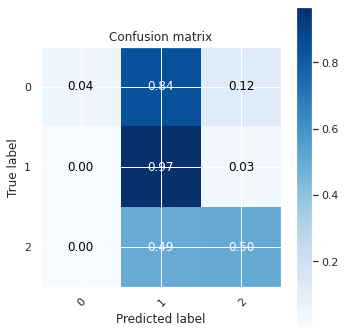

In [64]:
target_name=np.array(['0', '1', '2'], dtype='<U10')
plot_confusion_matrix(y_test, y_pred, classes=target_name, normalize=True,
                      title='Confusion matrix')
  

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.14      0.18       427
           1       0.81      0.95      0.88      5747
           2       0.66      0.24      0.35      1261

    accuracy                           0.79      7435
   macro avg       0.58      0.44      0.47      7435
weighted avg       0.75      0.79      0.75      7435



### Naive Bayes algorithm

This algorithm is based on Bayes' Theorem. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [ ]:
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB



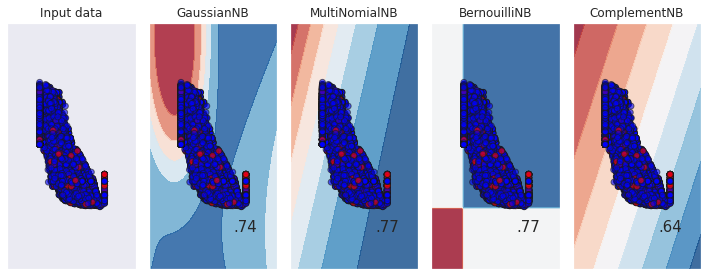

In [ ]:
# Plotting variables
h = .02  # step size in the mesh
i = 1
figure = plt.figure(figsize=(10, 4))

# Classifiers
names = ["GaussianNB", "MultiNomialNB", 'BernouilliNB', 'ComplementNB']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()]

# Scale
X = MinMaxScaler().fit_transform(X)
# Train and test
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)


# Prepare visualization
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

# Just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
         edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
              edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

for name, clf in zip(names, classifiers):
  ax = plt.subplot(1, len(classifiers) + 1, i)
  
  # FIT THE MODEL
  clf.fit(X_train, y_train)
  # PREDIT AND SCORE  
  score = clf.score(X_test, y_test) #Returns the mean accuracy on the given test data and labels.
  
  
  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

  # Plot the training points
  ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
             edgecolors='k')
  # Plot the testing points
  ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
             edgecolors='k', alpha=0.6)

  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.set_xticks(())
  ax.set_yticks(())
  ax.set_title(name)
  ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
          size=15, horizontalalignment='right')
  i += 1
  
plt.tight_layout()
plt.show()

In [ ]:
clf = GaussianNB() # Classifier chosen
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.7360230547550433


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

**Confusion Matrix**

Normalized confusion matrix
[[0.         0.89664083 0.10335917]
 [0.         0.87090774 0.12909226]
 [0.         0.63806287 0.36193713]]


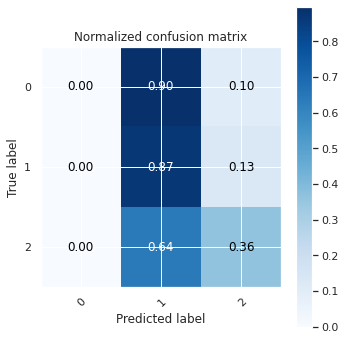

In [ ]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')

**Classification Report**

In [ ]:
print(classification_report(test['class'], y_pred)) ### FALLA, NO SE.

ValueError: ignored